# Setup

In [1]:
%%capture --no-stderr
%pip install -U --quiet langchain-community tiktoken langchain-openai langchainhub chromadb langchain langgraph langchain-text-splitters

In [2]:
import getpass
import os

def _set_env(key: str):
    if key not in os.environ:
        os.environ[key] = getpass.getpass(f"{key}:")

_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")
_set_env("LANGCHAIN_API_KEY")
_set_env("LANGCHAIN_TRACING_V2")
_set_env("LANGCHAIN_ENDPOINT")
_set_env("LANGCHAIN_PROJECT")

# Retriever

In [3]:
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma
from tqdm import tqdm


# 임베딩 모델 설정
model_name = "BAAI/bge-m3"
hf_embeddings = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs = {'device': 'cpu'}, # default
    encode_kwargs = {'normalize_embeddings': False}, # default
)

persist_dir = "./chroma_db" # 벡터 DB 저장경로

# docs_list와 컬렉션 이름 매핑
collections = {
    "careernet_job_db": {
        "search_type":"mmr",
        "search_kwargs":{
            "k": 5,
        }, 
    },
    "careernet_major_db": {
        "search_type":"mmr",
        "search_kwargs":{
            "k": 4,
        }, 
    },
    "careernet_univ_db": {
        "search_type":"similarity",
        "search_kwargs":{
            "k": 3,
        }, 
    }
}

retrievers = []
for item in collections:
    # 직업백과 벡터 데이터베이스 불러오기
    vectorstore = Chroma(
        embedding_function=hf_embeddings,  # 사용한 임베딩 모델과 동일한 함수
        persist_directory=persist_dir,     # 벡터 데이터베이스가 저장된 경로
        collection_name=item # 불러올 컬렉션 이름
    ) 
    retriever = vectorstore.as_retriever(
        search_type=collections[item]["search_type"],
        search_kwargs=collections[item]["search_kwargs"]     
    )
    retrievers.append(retriever)
    
    
print(retrievers)

/Users/ormor/root/DoWADO/Dowado-v2-Server/.venv/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
/var/folders/n9/ts1r4j4j5r7c_b_rychx69lw0000gn/T/ipykernel_55489/2079095718.py:41: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(


[VectorStoreRetriever(tags=['Chroma', 'HuggingFaceEmbeddings'], vectorstore=<langchain_community.vectorstores.chroma.Chroma object at 0x11af6f310>, search_type='mmr', search_kwargs={'k': 5}), VectorStoreRetriever(tags=['Chroma', 'HuggingFaceEmbeddings'], vectorstore=<langchain_community.vectorstores.chroma.Chroma object at 0x17ec36610>, search_type='mmr', search_kwargs={'k': 4}), VectorStoreRetriever(tags=['Chroma', 'HuggingFaceEmbeddings'], vectorstore=<langchain_community.vectorstores.chroma.Chroma object at 0x324918b10>, search_kwargs={'k': 3})]


In [4]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.tools.retriever import create_retriever_tool


# 벡터 DB 검색 도구
# retrievers = [직업백과, 전공정보, 대학정보]
job_retriever_tool = create_retriever_tool(
    retrievers[0],
    "retrieve_job_informations",
    "Search and return information about a specific job, including related job titles, academic majors, certifications, key responsibilities, aptitudes, career exploration activities, educational pathways, employment methods, job outlook, salary, job satisfaction, required skills, knowledge, and working environments.",
)

major_retriever_tool = create_retriever_tool(
    retrievers[1],
    "retrieve_major_informations",
    "Search and return information about a specific academic major, including employment rate, average starting salary, detailed description of the major, key characteristics, relevant aptitudes and interests, high school subjects, important college courses, career paths after graduation, career exploration activities, related certifications, associated job fields, detailed sub-majors, universities name offering the major, and interviews with professors.",
)

univ_retriever_tool = create_retriever_tool(
    retrievers[2],
    "retrieve_university_informations",
    "Search and return information about a specific university, including its name, university webpage URL, type of school (e.g., college, university), category (e.g., technical, polytechnic), founding type (e.g., public, private), location, and other relevant data.",
)

# 웹 검색 도구
tavily_tool = TavilySearchResults(max_results=5)


tools = [job_retriever_tool, major_retriever_tool, univ_retriever_tool, tavily_tool]

# Agent State

In [5]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

# Node and Edges

In [6]:
from typing import Annotated, Literal, Sequence
from typing_extensions import TypedDict
from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
from langgraph.prebuilt import tools_condition


### Edges
def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("🟠 [GRADE] 쿼리<->검색된 문서 관련성 유무 확인 중")

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM
    model = ChatOpenAI(temperature=0, model="gpt-3.5-turbo-0125", streaming=True)

    # LLM with tool and validation
    llm_with_tool = model.with_structured_output(grade)

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | llm_with_tool

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question": question, "context": docs})

    score = scored_result.binary_score

    if score == "yes":
        print("🟠 [GRADE] 결정: 관련성 있음")
        return "generate"

    else:
        print("🟠 [GRADE] 결정: 관련성 없음")
        print(score)
        return "rewrite"


### Nodes
def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("⚪️ [AGENT] 에이전트 호출")
    messages = state["messages"]
    model = ChatOpenAI(temperature=0, streaming=True, model="gpt-3.5-turbo-0125")
    model = model.bind_tools(tools)
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("🔵 [REWRITE] 쿼리 변환 중")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # Grader
    model = ChatOpenAI(temperature=0, model="gpt-3.5-turbo-0125", streaming=True)
    response = model.invoke(msg)
    return {"messages": [response]}


def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    print("🟢 [GENERATE] 답변 생성 중")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    docs = last_message.content

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")

    # LLM
    llm = ChatOpenAI(model_name="gpt-3.5-turbo-0125", temperature=0, streaming=True)

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}


print("*" * 20 + "Prompt[rlm/rag-prompt]" + "*" * 20)
prompt = hub.pull("rlm/rag-prompt").pretty_print()  # Show what the prompt looks like

********************Prompt[rlm/rag-prompt]********************
================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


# Graph

In [7]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

# 새 그래프 정의
workflow = StateGraph(AgentState)

# 순환할 노드를 정의합니다.
workflow.add_node("agent", agent)  # agent
retrieve = ToolNode([job_retriever_tool, major_retriever_tool, univ_retriever_tool, tavily_tool])
workflow.add_node("retrieve", retrieve)  # retrieval
workflow.add_node("rewrite", rewrite)  # Re-writing the question
workflow.add_node(
    "generate", generate
)  
# 문서의 관련성을 확인한 후 응답 생성하기
# 에이전트 노드를 호출하여 검색 여부를 결정
workflow.add_edge(START, "agent")

# 검색 여부 결정
workflow.add_conditional_edges(
    "agent",
    tools_condition, # agent의 결정 평가
    {
        "tools": "retrieve", # 조건 출력값을 그래프의 노드로 변환합니다.
        END: END,
    },
)

# `action` 노드가 호출된 후 Edges 를 가져옵니다.
workflow.add_conditional_edges(
    "retrieve",
    grade_documents, # agent 결정 평가
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# Compile
graph = workflow.compile()

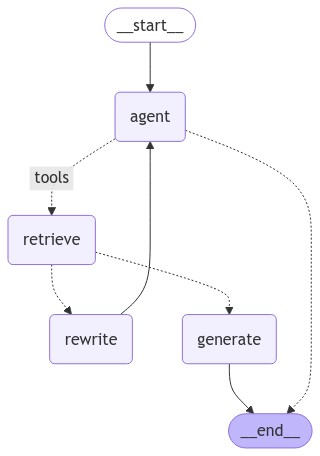

In [8]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # 여기에는 몇 가지 추가 종속성이 필요하며 선택 사항입니다.
    pass

# Invoke

---

In [9]:
import pprint

inputs = {
    "messages": [
        ("user", "데이터 사이언티스트가 되고 싶은데 관련된 전공은 어떤게 있는지 각 대학별로 구분지어서 간단히 리스트업 해줘"),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"👉🏻 [NODE] '{key}':")
        pprint.pprint(value, indent=2, width=80, depth=None)

⚪️ [AGENT] 에이전트 호출
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_yXZDELQAt4vBKPIu7pwuw3G2', 'function': {'arguments': '{"query": "data science"}', 'name': 'retrieve_major_informations'}, 'type': 'function'}, {'index': 1, 'id': 'call_psryeq07eTpyHNKn5bx1f9hW', 'function': {'arguments': '{"query": "data science major"}', 'name': 'retrieve_university_informations'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-3.5-turbo-0125'}, id='run-53dd886f-fa35-46f3-af3f-5240f7f52d19-0', tool_calls=[{'name': 'retrieve_major_informations', 'args': {'query': 'data science'}, 'id': 'call_yXZDELQAt4vBKPIu7pwuw3G2', 'type': 'tool_call'}, {'name': 'retrieve_university_informations', 'args': {'query': 'data science major'}, 'id': 'call_psryeq07eTpyHNKn5bx1f9hW', 'type': 'tool_call'}])]}
'\n---\n'
🟠 [GRADE] 쿼리<->검색된 문서 관련성 유무 확인 중
🟠 [GRADE] 결정: 관련성 있음
"Output from node 'retrieve

In [10]:
import pprint

inputs = {
    "messages": [
        ("user", "저는 기계공학과에 진학하고 싶고, 졸업 후 3D 프린팅 전문가로 일하고 싶은데, 이 직업에 적합한 전공 과목과 관련된 자격증, 그리고 이 전공을 제공하는 대학 중 취업률이 높은 대학은 어디인가요?"),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"👉🏻 [NODE] '{key}':")
        pprint.pprint(value, indent=2, width=80, depth=None)

⚪️ [AGENT] 에이전트 호출
"👉🏻 [NODE] 'agent':"
{ 'messages': [ AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_iG4HPYyYv8BWGS32edjpgFL8', 'function': {'arguments': '{"query": "기계공학"}', 'name': 'retrieve_major_informations'}, 'type': 'function'}, {'index': 1, 'id': 'call_0U7yt9XK04iqtT2lDxIDfcH7', 'function': {'arguments': '{"query": "3D 프린팅 전문가"}', 'name': 'retrieve_job_informations'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-3.5-turbo-0125'}, id='run-d419f171-bbcc-45eb-8734-f3e074b0fb4d-0', tool_calls=[{'name': 'retrieve_major_informations', 'args': {'query': '기계공학'}, 'id': 'call_iG4HPYyYv8BWGS32edjpgFL8', 'type': 'tool_call'}, {'name': 'retrieve_job_informations', 'args': {'query': '3D 프린팅 전문가'}, 'id': 'call_0U7yt9XK04iqtT2lDxIDfcH7', 'type': 'tool_call'}])]}
🟠 [GRADE] 쿼리<->검색된 문서 관련성 유무 확인 중
🟠 [GRADE] 결정: 관련성 없음
no
"👉🏻 [NODE] 'retrieve':"
{ 'messages': [ ToolMessage(content='### 전공 특성  \n최근에는 4차산업혁명 관련 기술인 